# Week of 2025.07.16

I am coming back from a one month sabbatical. I spoke with Mario yesterday, the main takeways were:
1. The infrasound work is still outstanding, there has not been significant progress on that since I left.
2. He is working on two things primarily:
    a. sensativity analysis (exploring parameter space -- height, traction, etc -- to see affect on seismic data)
    b. model validation -> show that the model is stable under changes like permuting the size of the mesh. Verify that the system is not chaotic. That is to say not suseptiable to small permutations in intitial conditions. 

## Where I left things
Here are my [last week of notes](https://paxtonsc.github.io/files/geophysics/volcano_project/weekly_notes/2025.06.02.experiments.html) before I departed. Right before, I had departed we decided that we were seeing numerical diffusion between the melt and the atmosphere causing very funky things with the atmosphere. That diffusion should not matter in cases of high exit velocity though, so it is unclear if that is related to the original problem we were having with the atmospheric pairing. 

## Review of problems 
- [ ] When modeling the atmosphere of Mario's reasonably complicated eruption files we were getting results that were very hard to validate. As a result, prior to departing I had simplified the problem to just model the 2D atmosphere in the vertical conduit with the toy problem.
- [ ] In that simple problem (and the real simulation) we were running into issues with diffusive error. One solution we discussed was to break the solution into two steps. First, to solve without atmosphere. Then, once the eruption was going to solve with atmosphere. With large velocity, the diffusion would not be a problem.  TBD what exactly the transition condition should be. 

## My goals for the week
- [x] Remind myself where I left things with the infrasound work 1 month ago. 
- [x] Build infrasound simulation from the ground up, taking the following steps:
    - [x] Match analytical solution with 1D conduit simulation paired with 1D atmosphere.
    - [x] Run the simulation at multiple levels of resolution to see how the diffusion effects the result. 
    - [x] Build up a work flow to run two simulations (one without atmosphere and the next with an atmosphere). Basically the first one will output the initial conditions for the second one. That will basically include a vector for pressure, velocity, etc. A simple way of doing this would be to simply have one initial condition accept an arbitrary vector. And we would manually populate the vector from the output of the first simulation. That seems a little hacky, but not sure if there is a better way to do it. 
    - [] Once we have the workflow, analyze the Pevlet number to get a since of when we cut over from no-atmosphere to atmosphere. 

## Questions:
- [] Why is Uq state for initial conditions 200 by *3* by 9? 

## Review toy eruption

It's been a second; let's review the toy eruption example I have set up. The physics of this toy model are very easy to understand. In fact, I described the setup up for that toy eruption pretty clearly [here](https://paxtonsc.github.io/projects/2025/05/geophysics-volcano-research/).

In [1]:
%load_ext autoreload
%autoreload 2

In [51]:
from helper_code.slip_imports import *
from helper_code.helper_functions import get_local_solver_from_index_func, get_quantities_at_conduit_exit, get_quantities_at_all_space
from helper_code.animate import animate_conduit_pressure
from helper_code.analytical_solution import get_lumped_solution

import helper_code.infrasound as infrasound
from matplotlib.animation import FuncAnimation

import matplotlib.pyplot as plt 
plt.rcParams['animation.ffmpeg_path'] = '/opt/homebrew/bin/ffmpeg'

folder_name = "simple_conduit"

ITERS = 50
D_ITERS = 1
END_TIME = 20
C0 = 320 # m/s at 5000m

In [6]:
file_name = "short_plug_v12"
iters = 50
solver_func = get_local_solver_from_index_func(folder_name, file_name)
ani = animate_conduit_pressure(
    solver_func,
    iterations=iters,
    d_iterations=D_ITERS,
    viscosity_index=2,
    wall_friction_index=1,
    max_velocity=5,
    max_slip=60,
    max_tau=1.5,
    max_pressure=50,
    max_speed_of_sound=1000,
    max_water=1,
    max_density=5e3,
    max_fragmentation=5000,
    max_crystal=100,
    max_viscosity=0.1,
)

ani.save(
    f"{BASE_PATH}/volcano_sims/notebooks/animations/small_controlled_eruption.mp4",
    writer="ffmpeg",
    fps=10,
    bitrate=1800,
)
HTML(ani.to_html5_video())

## Comparing to the analytical solution 

Because it has been a little while since I have worked with this example, let's show again that the dynamics of the eruption can be easily modeled with a lumped parameter model. 

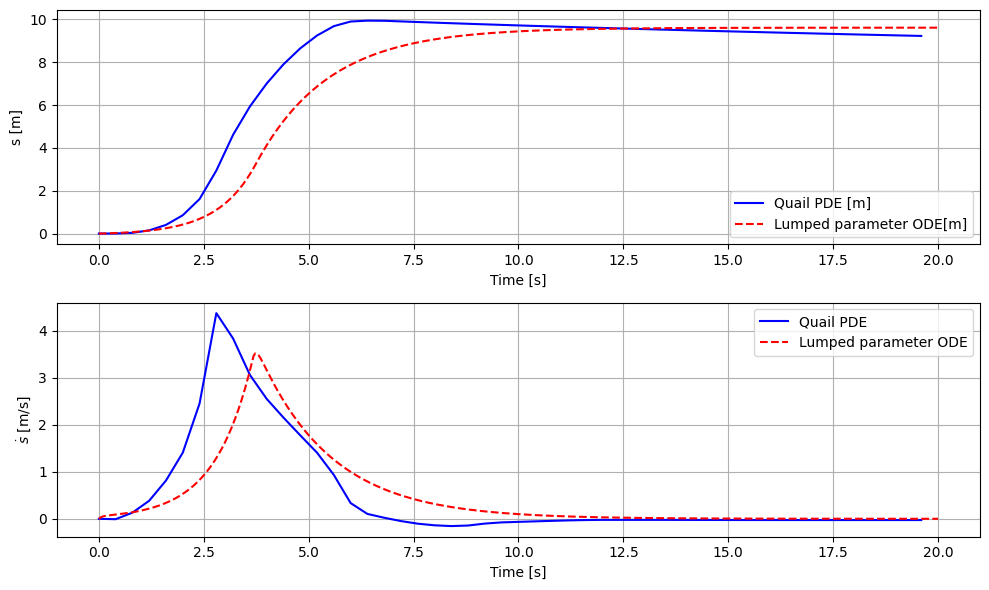

In [13]:
file_name = "short_plug_v12"
solver_func = get_local_solver_from_index_func(folder_name, file_name)
t_quail, p_quail, slip_quail, u_quail, _ = get_quantities_at_conduit_exit(
    solver_func, iterations=50, compute_temp=True, conduit_index=-1
)

t_analytical, slip_analytical, u_analytical = get_lumped_solution(
    K=1e9,
    L_melt=950,
    tau_p=1e6,
    tau_r=0,
    R=10,
    L_plug=50,
    rho=2.6e3,
    mu=5e4,
    D_c=3,
    C=600,
    p0=11.5e6,
    p_atm=1e5,
)


# Plot results
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.plot(t_quail, slip_quail, "b-", label="Quail PDE [m]")
plt.plot(t_analytical, slip_analytical, "r--", label="Lumped parameter ODE[m]")
plt.xlabel("Time [s]")
plt.ylabel("s [m]")
plt.grid(True)
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(t_quail, u_quail, "b-", label="Quail PDE")
plt.plot(t_analytical, u_analytical, "r--", label="Lumped parameter ODE")
plt.xlabel("Time [s]")
plt.ylabel(r"$\dot{s}$ [m/s]")
plt.grid(True)
plt.legend()

plt.savefig(f"{BASE_PATH}/volcano_sims/notebooks/charts/lumped_parameter_model.png")
plt.tight_layout()
plt.show()

## Pair with 1D atmosphere

Let's try to proceed with the smallest baby steps. For our first test, let's just try to pair this simulation with a 1d atmosphere. If we do this correctly we should be able to verify the numerical solution against an analytical solution.

Furthermore, if we see the same diffusion challenges from the 2D atmosphere pairing we might be able to increase the resolution of the model to effectively remove significant diffusion effects. 

### Review the eruption with the paired 1D atmosphere

We expect to see some amount of diffusion here causing odd behavior around the boundary (y=0). Indeed we do see that. 

In [19]:
file_name = "short_plug_v0"
folder_name = "simple_conduit_1d_atmosphere"
iters = 100
solver_func = get_local_solver_from_index_func(folder_name, file_name)
ani = animate_conduit_pressure(
    solver_func,
    iterations=iters,
    d_iterations=4,
    viscosity_index=2,
    wall_friction_index=1,
    max_velocity=5,
    max_slip=60,
    max_tau=1.5,
    max_pressure=50,
    max_speed_of_sound=1000,
    max_water=1,
    max_density=5e3,
    max_fragmentation=5000,
    max_crystal=100,
    max_viscosity=0.1,
)

ani.save(
    f"{BASE_PATH}/volcano_sims/notebooks/animations/small_controlled_eruption.mp4",
    writer="ffmpeg",
    fps=10,
    bitrate=1800,
)
HTML(ani.to_html5_video())

### Compare position/velocity with the example that is not paired with the atmosphere

As we can see blow, the diffusive nature of the simulation results in some very peculiar outputs (at least for velocity at the outlet).

In [41]:
file_name = "short_plug_v0"
folder_name = "simple_conduit_1d_atmosphere"
solver_func = get_local_solver_from_index_func(folder_name, file_name)
t_quail_w_atm, p_quail_w_atm, slip_quail_w_atm, u_quail_w_atm, _ = get_quantities_at_conduit_exit(
    solver_func, iterations=100, compute_temp=True, conduit_index=-1
)

file_name = "short_plug_v1"
folder_name = "simple_conduit_1d_atmosphere"
solver_func = get_local_solver_from_index_func(folder_name, file_name)
t_quail_w_atm_1, p_quail_w_atm_1, slip_quail_w_atm_1, u_quail_w_atm_1, _ = get_quantities_at_conduit_exit(
    solver_func, iterations=100, compute_temp=True, conduit_index=-1
)

file_name = "short_plug_v2"
folder_name = "simple_conduit_1d_atmosphere"
solver_func = get_local_solver_from_index_func(folder_name, file_name)
t_quail_w_atm_2, p_quail_w_atm_2, slip_quail_w_atm_2, u_quail_w_atm_2, _ = get_quantities_at_conduit_exit(
    solver_func, iterations=100, compute_temp=True, conduit_index=-1
)

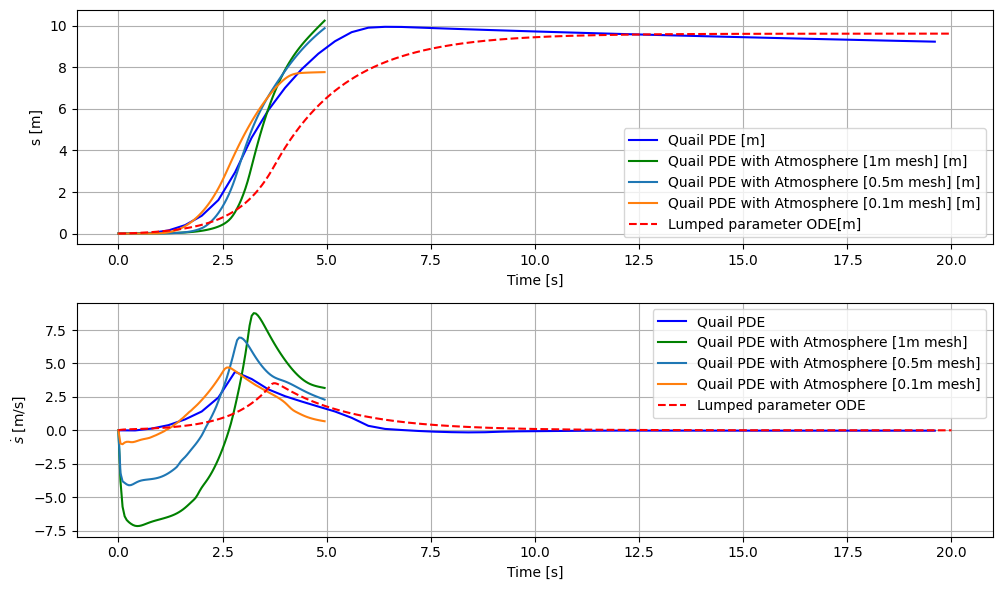

In [42]:
# Plot results
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.plot(t_quail, slip_quail, "b-", label="Quail PDE [m]")
plt.plot(t_quail_w_atm, slip_quail_w_atm, "g-", label="Quail PDE with Atmosphere [1m mesh] [m]")
plt.plot(t_quail_w_atm_1, slip_quail_w_atm_1, label="Quail PDE with Atmosphere [0.5m mesh] [m]")
plt.plot(t_quail_w_atm_2, slip_quail_w_atm_2, label="Quail PDE with Atmosphere [0.1m mesh] [m]")
plt.plot(t_analytical, slip_analytical, "r--", label="Lumped parameter ODE[m]")
plt.xlabel("Time [s]")
plt.ylabel("s [m]")
plt.grid(True)
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(t_quail, u_quail, "b-", label="Quail PDE")
plt.plot(t_quail_w_atm, u_quail_w_atm, "g-", label="Quail PDE with Atmosphere [1m mesh]")
plt.plot(t_quail_w_atm_1, u_quail_w_atm_1, label="Quail PDE with Atmosphere [0.5m mesh]")
plt.plot(t_quail_w_atm_2, u_quail_w_atm_2, label="Quail PDE with Atmosphere [0.1m mesh]")
plt.plot(t_analytical, u_analytical, "r--", label="Lumped parameter ODE")
plt.xlabel("Time [s]")
plt.ylabel(r"$\dot{s}$ [m/s]")
plt.grid(True)
plt.legend()

plt.savefig(f"{BASE_PATH}/volcano_sims/notebooks/charts/lumped_parameter_model.png")
plt.tight_layout()
plt.show()

We can see above that as our spatial resolution increases the quail model with atmosphere converges towards to the model without atmosphere.


### Let's review the actual output in the atmosphere

We can see in the below example that when we increase the spatial resolution to 0.1 m that is sufficient to make the atmosphere model look pretty good. 

In [47]:
file_name = "vertical_atmosphere_01_atm1"
folder_name = "simple_conduit_1d_atmosphere"
iters = 100
solver_func = get_local_solver_from_index_func(folder_name, file_name)
ani = animate_conduit_pressure(
    solver_func,
    iterations=iters,
    d_iterations=5,
    viscosity_index=2,
    wall_friction_index=1,
    min_velocity=-10,
    max_velocity=10,
    max_slip=60,
    max_tau=1.5,
    max_pressure=0.11,
    min_pressure=0.09,
    max_speed_of_sound=1000,
    max_water=1,
    max_density=10,
    max_fragmentation=5000,
    max_crystal=100,
    max_viscosity=0.1,
    y_max=1000,
    y_min=0,
    is_atm=True,  # Set to True for atmospheric simulation
)

ani.save(
    f"{BASE_PATH}/volcano_sims/notebooks/animations/small_controlled_eruption.mp4",
    writer="ffmpeg",
    fps=10,
    bitrate=1800,
)
HTML(ani.to_html5_video())

## Two part simulation 

1. Model the no-atmosphere part of the simulation. 
2. Between 1-3 seconds, lets take the final conditions from the first simulation and use as the initial conditions for the second simulation (which includes atmosphere).

In [71]:
file_name = "short_plug_v0"
folder_name = "simple_conduit_no_atmosphere"
iters = 100
solver_func = get_local_solver_from_index_func(folder_name, file_name)
ani = animate_conduit_pressure(
    solver_func,
    iterations=iters,
    d_iterations=4,
    viscosity_index=2,
    wall_friction_index=1,
    max_velocity=5,
    max_slip=60,
    max_tau=1.5,
    max_pressure=50,
    max_speed_of_sound=1000,
    max_water=1,
    max_density=5e3,
    max_fragmentation=5000,
    max_crystal=100,
    max_viscosity=0.1,
)

ani.save(
    f"{BASE_PATH}/volcano_sims/notebooks/animations/small_controlled_eruption.mp4",
    writer="ffmpeg",
    fps=10,
    bitrate=1800,
)
HTML(ani.to_html5_video())

Now, let's print out the values of each state variable to use as the initial conditions for the next part of the simulation.

In [115]:
file_name = "short_plug_1m"
folder_name = "simple_conduit_no_atmosphere"
solver_func = get_local_solver_from_index_func(folder_name, file_name)

rhoA, rhoWv, rhoM, momentum, energy, rhoWt, rhoC, rhoF, rhoSlip = get_quantities_at_all_space(solver_func, iter=15)

#print("arhoA=", np.array2string(rhoA.ravel(), separator=', ', suppress_small=True))
#print("arhoWv=", np.array2string(rhoWv.ravel(), separator=', ', suppress_small=True))
#print("arhoM=", np.array2string(rhoM.ravel(), separator=', ', suppress_small=True))
#print("momentum=", np.array2string(momentum.ravel(), separator=', ', suppress_small=True))
#print("energy=", np.array2string(energy.ravel(), separator=', ', suppress_small=True))
#print("arhoWt=", np.array2string(rhoWt.ravel(), separator=', ', suppress_small=True))
#print("arhoC=", np.array2string(rhoC.ravel(), separator=', ', suppress_small=True))
#print("arhoF=", np.array2string(rhoF.ravel(), separator=', ', suppress_small=True))
#print("arhoSlip=", np.array2string(rhoSlip.ravel(), separator=', ', suppress_small=True))

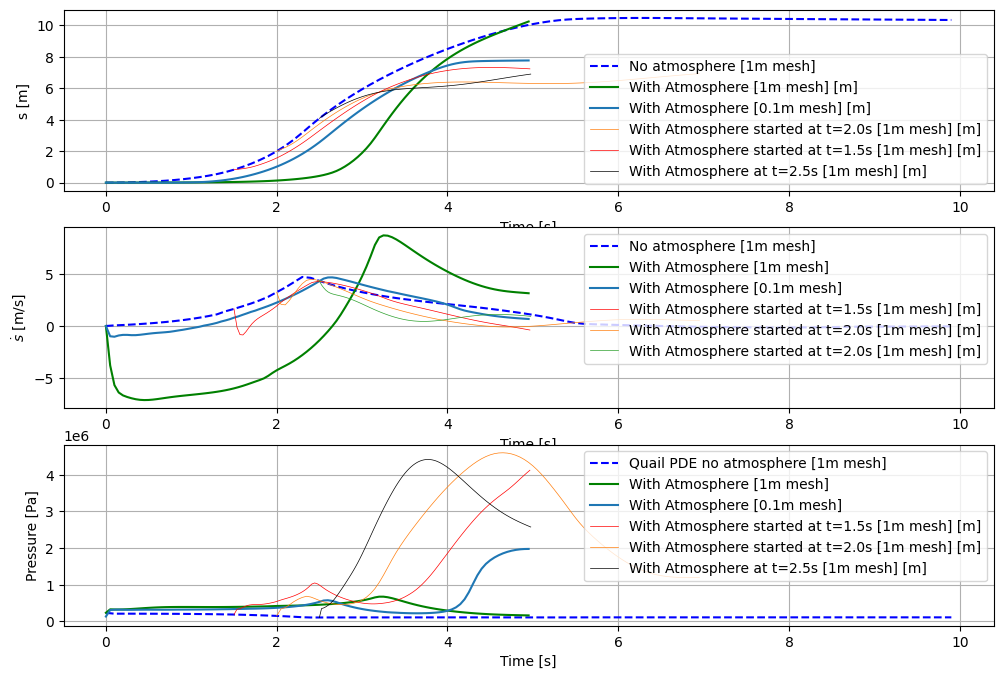

In [121]:
file_name = "short_plug_1m"
folder_name = "simple_conduit_no_atmosphere"
solver_func = get_local_solver_from_index_func(folder_name, file_name)
t_quail_w_no_atm, p_quail_w_no_atm, slip_quail_w_no_atm, u_quail_w_no_atm, _ = get_quantities_at_conduit_exit(
    solver_func, iterations=100, compute_temp=True, conduit_index=-1
)

file_name =  "short_plug_1_5m_1s"
folder_name = "simple_conduit_1d_atmosphere"
solver_func = get_local_solver_from_index_func(folder_name, file_name)
t_quail_atm_1_5s, p_quail_atm_1_5s, slip_quail_atm_1_5s, u_quail_atm_1_5s, _ = get_quantities_at_conduit_exit(
    solver_func, iterations=100, compute_temp=True, conduit_index=-1
)

file_name =  "short_plug_1m_2s"
folder_name = "simple_conduit_1d_atmosphere"
solver_func = get_local_solver_from_index_func(folder_name, file_name)
t_quail_atm_2s, p_quail_atm_2s, slip_quail_atm_2s, u_quail_atm_2s, _ = get_quantities_at_conduit_exit(
    solver_func, iterations=100, compute_temp=True, conduit_index=-1
)

file_name = "short_plug_1m_2_5s"
folder_name = "simple_conduit_1d_atmosphere"
solver_func = get_local_solver_from_index_func(folder_name, file_name)
t_quail_w_atm_2_5s, p_quail_w_atm_2_5s, slip_quail_w_atm_2_5s, u_quail_w_atm_2_5s, _ = get_quantities_at_conduit_exit(
    solver_func, iterations=100, compute_temp=True, conduit_index=-1
)   


# Plot results
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(t_quail_w_no_atm, slip_quail_w_no_atm, "b--", label="No atmosphere [1m mesh]")
plt.plot(t_quail_w_atm, slip_quail_w_atm, "g-", label="With Atmosphere [1m mesh] [m]")
plt.plot(t_quail_w_atm_2, slip_quail_w_atm_2, label="With Atmosphere [0.1m mesh] [m]")
plt.plot(t_quail_atm_2s + t_quail_w_no_atm[20], slip_quail_atm_2s, linewidth=0.5, label="With Atmosphere started at t=2.0s [1m mesh] [m]")
plt.plot(t_quail_atm_1_5s, slip_quail_atm_1_5s, 'r-', linewidth=0.5, label="With Atmosphere started at t=1.5s [1m mesh] [m]")
plt.plot(t_quail_w_atm_2_5s, slip_quail_w_atm_2_5s, 'k-', linewidth=0.5, label="With Atmosphere at t=2.5s [1m mesh] [m]")
plt.xlabel("Time [s]")
plt.ylabel("s [m]")
plt.grid(True)
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(t_quail_w_no_atm, u_quail_w_no_atm, "b--", label="No atmosphere [1m mesh]")
plt.plot(t_quail_w_atm, u_quail_w_atm, "g-", label="With Atmosphere [1m mesh]")
plt.plot(t_quail_w_atm_2, u_quail_w_atm_2, label="With Atmosphere [0.1m mesh]")
plt.plot(t_quail_atm_1_5s, u_quail_atm_1_5s, 'r-', linewidth=0.5, label="With Atmosphere started at t=1.5s [1m mesh] [m]")
plt.plot(t_quail_atm_2s + + t_quail_w_no_atm[20], u_quail_atm_2s, linewidth=0.5, label="With Atmosphere started at t=2.0s [1m mesh] [m]")
plt.plot(t_quail_w_atm_2_5s, u_quail_w_atm_2_5s, linewidth=0.5, label="With Atmosphere started at t=2.0s [1m mesh] [m]")
plt.xlabel("Time [s]")
plt.ylabel(r"$\dot{s}$ [m/s]")
plt.grid(True)
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(t_quail_w_no_atm, p_quail_w_no_atm, "b--", label="Quail PDE no atmosphere [1m mesh]")
plt.plot(t_quail_w_atm, p_quail_w_atm, "g-", label="With Atmosphere [1m mesh]")
plt.plot(t_quail_w_atm_2, p_quail_w_atm_2, label="With Atmosphere [0.1m mesh]")
plt.plot(t_quail_atm_1_5s, p_quail_atm_1_5s, 'r-', linewidth=0.5, label="With Atmosphere started at t=1.5s [1m mesh] [m]")
plt.plot(t_quail_atm_2s + + t_quail_w_no_atm[20], p_quail_atm_2s, linewidth=0.5, label="With Atmosphere started at t=2.0s [1m mesh] [m]")
plt.plot(t_quail_w_atm_2_5s, p_quail_w_atm_2_5s, 'k-', linewidth=0.5, label="With Atmosphere at t=2.5s [1m mesh] [m]")
plt.xlabel("Time [s]")
plt.ylabel(r"Pressure [Pa]")
plt.grid(True)
plt.legend()



## Below is a plot of the conduit flow when modeled with atmosphere, starting at t=2.0s into the simulation without atmosphere.

In [ ]:
file_name = "short_plug_1m_2s"
folder_name = "simple_conduit_1d_atmosphere"
iters = 100
solver_func = get_local_solver_from_index_func(folder_name, file_name)
ani = animate_conduit_pressure(
    solver_func,
    iterations=iters,
    d_iterations=4,
    viscosity_index=2,
    wall_friction_index=1,
    max_velocity=5,
    max_slip=60,
    max_tau=1.5,
    max_pressure=50,
    max_speed_of_sound=1000,
    max_water=1,
    max_density=5e3,
    max_fragmentation=5000,
    max_crystal=100,
    max_viscosity=0.1,
)

ani.save(
    f"{BASE_PATH}/volcano_sims/notebooks/animations/small_controlled_eruption.mp4",
    writer="ffmpeg",
    fps=10,
    bitrate=1800,
)
HTML(ani.to_html5_video())

## Conclusions

1. When we reduce the spatial discretization size to 0.1m, the velocity and slip graphs with atmosphere largely match the model with out atmosphere (which also roughly matches the lumped parameter model). However, even with 0.1m spacing we still can see a significant increase in density (and resulting decrease in sound speed) at the base of the 1D atmosphere. 

2. When we start the simulation at 2s (with the first 2s simulation without atmosphere), a `1m` discretization achieves a similar "accuracy" with the 0.1 m and atmosphere included for the full length of the simulation. 

3. For simulations without atmosphere, modeling the atmosphere as a constant 1e5 Pa likely results in incorrect pressure near the outlet. 

